# Workflows Demo

This notebook demonstrates the **py-workflows** package, which provides tools for composing preprocessing and models into complete pipelines.

## Why Workflows?

Workflows combine preprocessing (formulas or recipes) with model specifications into a single, reusable pipeline that:

- **Simplifies modeling**: All preprocessing and modeling in one object
- **Prevents data leakage**: Preprocessing fitted only on training data
- **Enables reuse**: Same workflow can be applied to new data
- **Supports tuning**: Easy to update components without rebuilding from scratch
- **Maintains consistency**: Same preprocessing applied to training and test data

## Setup

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest
from py_rsample import initial_split, training, testing

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style (use seaborn style if available, otherwise default)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('default')
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.figsize'] = (10, 6)

## 1. Prepare Sample Data

Let's create a dataset simulating house prices with multiple predictors.

In [2]:
# Generate synthetic house price data
n_samples = 500

# Features
square_feet = np.random.normal(2000, 500, n_samples)
bedrooms = np.random.randint(2, 6, n_samples)
bathrooms = np.random.randint(1, 4, n_samples)
age_years = np.random.randint(0, 50, n_samples)
lot_size = np.random.normal(8000, 2000, n_samples)

# Target: price (with some realistic relationships)
price = (
    150 * square_feet +
    25000 * bedrooms +
    30000 * bathrooms -
    2000 * age_years +
    50 * lot_size +
    np.random.normal(0, 50000, n_samples)
)

# Create DataFrame
houses = pd.DataFrame({
    "price": price,
    "square_feet": square_feet,
    "bedrooms": bedrooms,
    "bathrooms": bathrooms,
    "age_years": age_years,
    "lot_size": lot_size
})

print(f"Dataset shape: {houses.shape}")
houses.head()

Dataset shape: (500, 6)


,price,square_feet,bedrooms,bathrooms,age_years,lot_size
0,8.355966e+05,2248.357077,3,2,0,6837.529654
1,7.602013e+05,1930.867849,5,3,37,6208.981196
2,7.744424e+05,2323.844269,3,2,14,6866.409654
3,1.005925e+06,2761.514928,4,3,33,9056.650868
4,7.688973e+05,1882.923313,5,3,34,7712.308458


In [3]:
# Split into train and test sets
split = initial_split(houses, prop=0.75)
train_data = training(split)
test_data = testing(split)

print(f"Training set: {len(train_data)} observations")
print(f"Test set: {len(test_data)} observations")

Training set: 375 observations
Test set: 125 observations


## 2. Creating a Basic Workflow

A workflow combines:
1. **Preprocessor**: Formula (or recipe, in future versions)
2. **Model**: Model specification from py-parsnip

Let's create a simple linear regression workflow.

In [4]:
# Create a workflow with formula and linear regression
wf = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms + bathrooms + age_years + lot_size")
    .add_model(linear_reg().set_engine("sklearn"))
)

print("Workflow components:")
print(f"  Preprocessor: {wf.preprocessor}")
print(f"  Model: {wf.spec.mode} with {wf.spec.engine} engine")

Workflow components:
  Preprocessor: price ~ square_feet + bedrooms + bathrooms + age_years + lot_size
  Model: regression with sklearn engine


## 3. Fitting the Workflow

Fitting a workflow applies both preprocessing and model fitting in one step.

In [5]:
# Fit the workflow
wf_fit = wf.fit(train_data)

print("Workflow fitted successfully!")
print(f"Type: {type(wf_fit)}")

Workflow fitted successfully!
Type: <class 'py_workflows.workflow.WorkflowFit'>


## 4. Making Predictions

The fitted workflow can predict on new data, automatically applying the same preprocessing.

In [6]:
# Predict on test data
predictions = wf_fit.predict(test_data)

print(f"Predictions shape: {predictions.shape}")
predictions.head()

Predictions shape: (125, 1)


,.pred
0,7.664042e+05
1,7.928071e+05
2,7.725335e+05
3,1.085229e+06
4,9.943165e+05


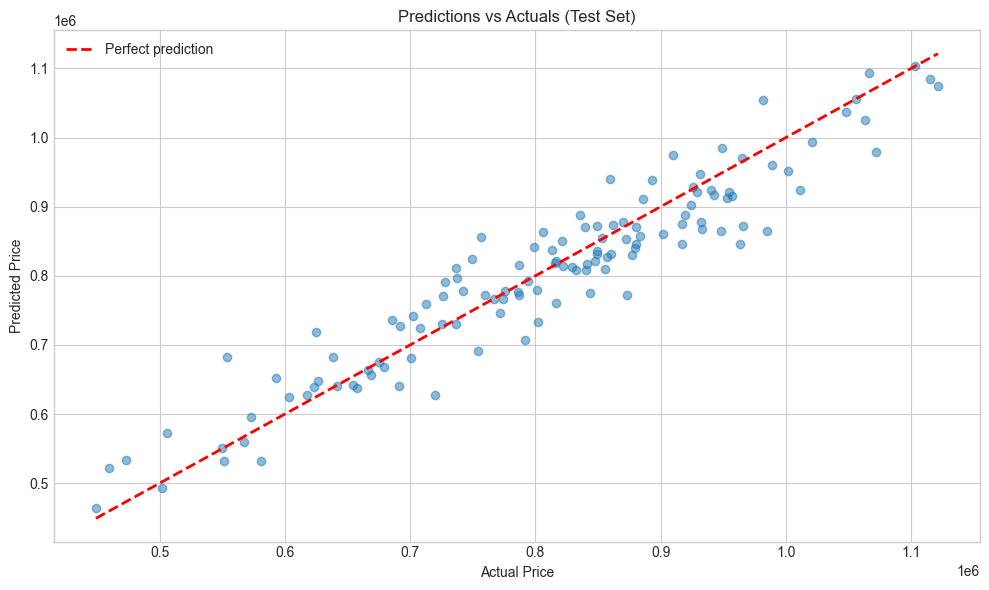

In [7]:
# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(test_data["price"], predictions[".pred"], alpha=0.5)
plt.plot([test_data["price"].min(), test_data["price"].max()],
         [test_data["price"].min(), test_data["price"].max()],
         'r--', lw=2, label='Perfect prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predictions vs Actuals (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Evaluating on Test Data

The `evaluate()` method stores test predictions for comprehensive train/test metrics.

In [8]:
# Evaluate on test data
wf_fit = wf_fit.evaluate(test_data)

print("Evaluation complete!")
print(f"Evaluation data keys: {list(wf_fit.fit.evaluation_data.keys())}")

Evaluation complete!
Evaluation data keys: ['test_data', 'test_predictions', 'outcome_col']


## 6. Extracting Comprehensive Outputs

The `extract_outputs()` method returns three DataFrames:

1. **Outputs**: Observation-level results (actuals, fitted, forecast, split)
2. **Coefficients**: Variable-level parameters (coefficient, std_error, p_value)
3. **Stats**: Model-level metrics by split (rmse, mae, r_squared, etc.)

In [9]:
# Extract all outputs
outputs, coefficients, stats = wf_fit.extract_outputs()

print("\n=== OUTPUTS (first 10 rows) ===")
print(outputs.head(10))

print("\n=== COEFFICIENTS ===")
print(coefficients)

print("\n=== STATS ===")
print(stats)


=== OUTPUTS (first 10 rows) ===
        actuals        fitted      forecast     residuals  split       model  \
0  8.355966e+05  8.258084e+05  8.355966e+05  8.355966e+05  train  linear_reg   
1  7.602013e+05  7.406366e+05  7.602013e+05  7.602013e+05  train  linear_reg   
2  7.744424e+05  8.064190e+05  7.744424e+05  7.744424e+05  train  linear_reg   
3  1.005925e+06  9.823638e+05  1.005925e+06  1.005925e+06  train  linear_reg   
4  7.688973e+05  8.121717e+05  7.688973e+05  7.688973e+05  train  linear_reg   
5  8.812515e+05  8.462133e+05  8.812515e+05  8.812515e+05  train  linear_reg   
6  9.415337e+05  9.000752e+05  9.415337e+05  9.415337e+05  train  linear_reg   
7  5.699620e+05  6.045415e+05  5.699620e+05  5.699620e+05  train  linear_reg   
8  7.477841e+05  7.858151e+05  7.477841e+05  7.477841e+05  train  linear_reg   
9  9.811136e+05  1.036826e+06  9.811136e+05  9.811136e+05  train  linear_reg   

  model_group_name   group  
0                   global  
1                   global  

In [10]:
outputs

,actuals,fitted,forecast,residuals,split,model,model_group_name,group
0,8.355966e+05,825808.395673,8.355966e+05,8.355966e+05,train,linear_reg,,global
1,7.602013e+05,740636.606868,7.602013e+05,7.602013e+05,train,linear_reg,,global
2,7.744424e+05,806418.953511,7.744424e+05,7.744424e+05,train,linear_reg,,global
3,1.005925e+06,982363.757459,1.005925e+06,1.005925e+06,train,linear_reg,,global
4,7.688973e+05,812171.650265,7.688973e+05,7.688973e+05,train,linear_reg,,global
...,...,...,...,...,...,...,...,...
495,8.702535e+05,877518.730499,8.702535e+05,-7.265218e+03,test,linear_reg,,global
496,5.672942e+05,560191.959839,5.672942e+05,7.102234e+03,test,linear_reg,,global
497,1.001946e+06,952182.767076,1.001946e+06,4.976300e+04,test,linear_reg,,global
498,9.547504e+05,921164.948247,9.547504e+05,3.358547e+04,test,linear_reg,,global


In [11]:
coefficients

,variable,coefficient,std_error,t_stat,p_value,ci_0.025,ci_0.975,vif,model,model_group_name,group
0,Intercept,0.000000,301940.402683,0.000000,1.000000,-593739.739571,593739.739571,NaN,linear_reg,,global
1,square_feet,145.345981,88.804046,1.636704,0.102545,-29.279510,319.971473,1.002212,linear_reg,,global
2,bedrooms,23894.233395,38247.311115,0.624730,0.532535,-51315.802557,99104.269346,1.007948,linear_reg,,global
3,bathrooms,27045.409731,51873.807535,0.521369,0.602422,-74959.955243,129050.774706,1.009626,linear_reg,,global
4,age_years,-2267.046996,2860.902444,-0.792424,0.428623,-7892.764711,3358.670719,1.003769,linear_reg,,global
5,lot_size,47.695834,20.672881,2.307169,0.021598,7.044397,88.347271,1.001840,linear_reg,,global


In [12]:
stats

,metric,value,split,model,model_group_name,group
0,rmse,51542.436959,train,linear_reg,,global
1,mae,41368.542125,train,linear_reg,,global
2,mape,5.356467,train,linear_reg,,global
3,smape,5.320478,train,linear_reg,,global
4,r_squared,0.863183,train,linear_reg,,global
5,mda,87.967914,train,linear_reg,,global
6,adj_r_squared,0.860953,train,linear_reg,,global
7,rmse,46751.70525,test,linear_reg,,global
8,mae,36555.092586,test,linear_reg,,global
9,mape,4.651251,test,linear_reg,,global



Train vs Test Metrics:
split              test         train
metric                               
mae        36555.092586  41368.542125
r_squared      0.899423      0.863183
rmse        46751.70525  51542.436959


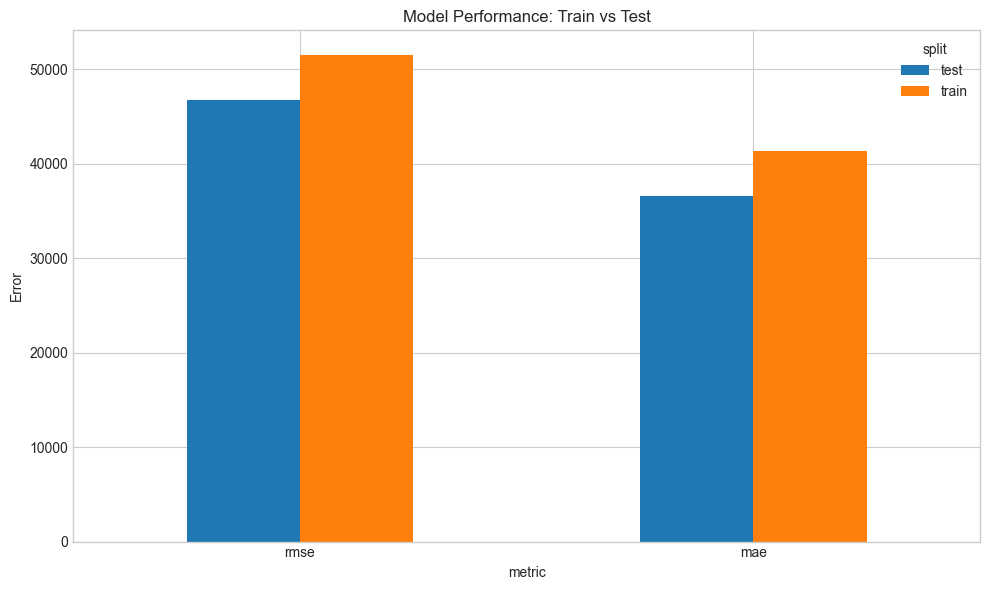

In [13]:
# Compare train vs test metrics
key_metrics = ["rmse", "mae", "r_squared"]
comparison = stats[stats["metric"].isin(key_metrics)].pivot(
    index="metric",
    columns="split",
    values="value"
)

print("\nTrain vs Test Metrics:")
print(comparison)

# Visualize metrics comparison
comparison_subset = comparison.loc[["rmse", "mae"]]
comparison_subset.plot(kind="bar", rot=0)
plt.title("Model Performance: Train vs Test")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

## 7. Method Chaining

Workflows support full method chaining for concise, readable code.

In [14]:
# Full pipeline in one chain
outputs2, coefficients2, stats2 = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms + bathrooms")
    .add_model(linear_reg().set_engine("sklearn"))
    .fit(train_data)
    .evaluate(test_data)
    .extract_outputs()
)

print("Method chaining complete!")
print(f"\nTest R²: {stats2[(stats2['metric'] == 'r_squared') & (stats2['split'] == 'test')]['value'].values[0]:.4f}")

Method chaining complete!

Test R²: 0.3752


## 8. Using Different Model Types

Workflows work with any py-parsnip model specification.

### 8.1 Regularized Linear Regression

In [15]:
# Ridge regression (penalty=0.1, mixture=0.0)
wf_ridge = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms + bathrooms + age_years + lot_size")
    .add_model(linear_reg(penalty=0.1, mixture=0.0).set_engine("sklearn"))
)

wf_ridge_fit = wf_ridge.fit(train_data).evaluate(test_data)
_, coeffs_ridge, stats_ridge = wf_ridge_fit.extract_outputs()

print("Ridge Regression Results:")
print(coeffs_ridge)

Ridge Regression Results:
      variable   coefficient  std_error  t_stat  p_value  ci_0.025  ci_0.975  \
0    Intercept      0.000000        NaN     NaN      NaN       NaN       NaN   
1  square_feet    145.345553        NaN     NaN      NaN       NaN       NaN   
2     bedrooms  23889.594225        NaN     NaN      NaN       NaN       NaN   
3    bathrooms  27034.968341        NaN     NaN      NaN       NaN       NaN   
4    age_years  -2267.018993        NaN     NaN      NaN       NaN       NaN   
5     lot_size     47.695761        NaN     NaN      NaN       NaN       NaN   

   vif       model model_group_name   group  
0  NaN  linear_reg                   global  
1  NaN  linear_reg                   global  
2  NaN  linear_reg                   global  
3  NaN  linear_reg                   global  
4  NaN  linear_reg                   global  
5  NaN  linear_reg                   global  


### 8.2 Random Forest

In [16]:
# Random forest
wf_rf = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms + bathrooms + age_years + lot_size")
    .add_model(
        rand_forest(trees=50, min_n=5)
        .set_mode("regression")
        .set_engine("sklearn")
    )
)

wf_rf_fit = wf_rf.fit(train_data).evaluate(test_data)
_, _, stats_rf = wf_rf_fit.extract_outputs()

print("Random Forest Results:")
rf_metrics = stats_rf[stats_rf["metric"].isin(["rmse", "mae", "r_squared"])]
print(rf_metrics)

Random Forest Results:
       metric         value  split        model model_group_name   group
0        rmse   30438.31076  train  rand_forest                   global
1         mae  24122.556112  train  rand_forest                   global
4   r_squared      0.952285  train  rand_forest                   global
7        rmse  63054.715348   test  rand_forest                   global
8         mae  50373.104559   test  rand_forest                   global
11  r_squared      0.817047   test  rand_forest                   global


### 8.3 Model Comparison


Model Comparison (Test Set):
Metric                  mae  r_squared          rmse
Model                                               
OLS            36555.092586   0.899423  46751.705250
Random Forest  50373.104559   0.817047  63054.715348
Ridge          36555.912147   0.899420  46752.290633


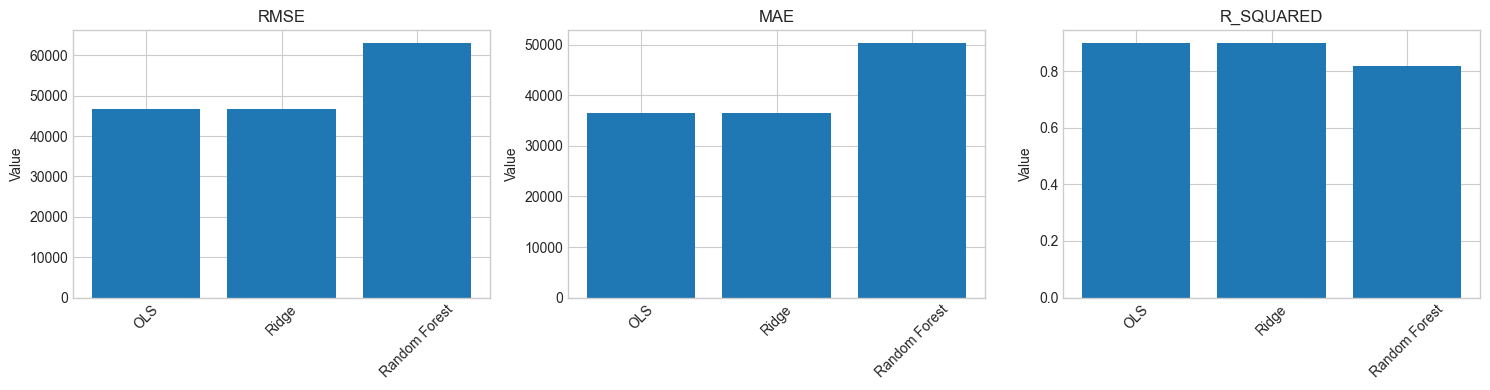

In [17]:
# Compare all models
comparison_data = []

for name, model_stats in [("OLS", stats), ("Ridge", stats_ridge), ("Random Forest", stats_rf)]:
    test_stats = model_stats[model_stats["split"] == "test"]
    for metric in ["rmse", "mae", "r_squared"]:
        value = test_stats[test_stats["metric"] == metric]["value"].values[0]
        comparison_data.append({"Model": name, "Metric": metric, "Value": value})

comparison_df = pd.DataFrame(comparison_data)
pivot_comparison = comparison_df.pivot(index="Model", columns="Metric", values="Value")

print("\nModel Comparison (Test Set):")
print(pivot_comparison)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(["rmse", "mae", "r_squared"]):
    subset = comparison_df[comparison_df["Metric"] == metric]
    axes[idx].bar(subset["Model"], subset["Value"])
    axes[idx].set_title(metric.upper())
    axes[idx].set_ylabel("Value")
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Updating Workflows

Workflows are immutable, but you can create updated versions using `update_*()` methods.

In [18]:
# Start with a basic workflow
wf_base = (
    workflow()
    .add_formula("price ~ square_feet")
    .add_model(linear_reg().set_engine("sklearn"))
)

print("Original formula:", wf_base.preprocessor)

# Update to include more predictors
wf_updated = wf_base.update_formula("price ~ square_feet + bedrooms + bathrooms")

print("Updated formula:", wf_updated.preprocessor)
print("Original unchanged:", wf_base.preprocessor)

# Fit and compare
fit_base = wf_base.fit(train_data).evaluate(test_data)
fit_updated = wf_updated.fit(train_data).evaluate(test_data)

_, _, stats_base = fit_base.extract_outputs()
_, _, stats_updated = fit_updated.extract_outputs()

print("\nBase R² (test):", 
      stats_base[(stats_base['metric'] == 'r_squared') & (stats_base['split'] == 'test')]['value'].values[0])
print("Updated R² (test):", 
      stats_updated[(stats_updated['metric'] == 'r_squared') & (stats_updated['split'] == 'test')]['value'].values[0])

Original formula: price ~ square_feet
Updated formula: price ~ square_feet + bedrooms + bathrooms
Original unchanged: price ~ square_feet

Base R² (test): 0.2928749173663696
Updated R² (test): 0.3752471064573588


## 10. Extracting Individual Components

You can extract specific components from fitted workflows.

In [19]:
# Extract components
model_fit = wf_fit.extract_fit_parsnip()
preprocessor = wf_fit.extract_preprocessor()
model_spec = wf_fit.extract_spec_parsnip()

print("Extracted components:")
print(f"  Model fit type: {type(model_fit)}")
print(f"  Preprocessor: {preprocessor}")
print(f"  Model spec: {model_spec.mode} with {model_spec.engine} engine")

# Access underlying sklearn model
sklearn_model = model_fit.fit_data["model"]
print(f"\n  Underlying model type: {type(sklearn_model)}")
print(f"  Number of coefficients: {len(sklearn_model.coef_)}")

Extracted components:
  Model fit type: <class 'py_parsnip.model_spec.ModelFit'>
  Preprocessor: price ~ square_feet + bedrooms + bathrooms + age_years + lot_size
  Model spec: regression with sklearn engine

  Underlying model type: <class 'sklearn.linear_model._base.LinearRegression'>
  Number of coefficients: 6


## 11. Workflow vs Direct Parsnip Usage

Let's compare the workflow approach with direct parsnip usage.

### Direct Parsnip Approach

In [20]:
# Direct parsnip usage
spec_direct = linear_reg().set_engine("sklearn")
fit_direct = spec_direct.fit(train_data, "price ~ square_feet + bedrooms")
pred_direct = fit_direct.predict(test_data)

print("Direct parsnip approach:")
print(f"  Predictions shape: {pred_direct.shape}")
print(pred_direct.head())

Direct parsnip approach:
  Predictions shape: (125, 1)
           .pred
0  722560.050074
1  898432.770030
2  820386.086870
3  920077.231596
4  771416.466141


### Workflow Approach

In [21]:
# Workflow approach
wf_compare = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms")
    .add_model(linear_reg().set_engine("sklearn"))
)
fit_wf = wf_compare.fit(train_data)
pred_wf = fit_wf.predict(test_data)

print("\nWorkflow approach:")
print(f"  Predictions shape: {pred_wf.shape}")
print(pred_wf.head())

# Verify they're the same
print(f"\nPredictions match: {np.allclose(pred_direct['.pred'], pred_wf['.pred'])}")


Workflow approach:
  Predictions shape: (125, 1)
           .pred
0  722560.050074
1  898432.770030
2  820386.086870
3  920077.231596
4  771416.466141

Predictions match: True


### Advantages of Workflows

1. **Single object**: Everything bundled together
2. **Reusability**: Easy to save and reload entire pipeline
3. **Clarity**: Clear separation of preprocessing and modeling
4. **Future-proof**: Ready for recipes when implemented
5. **Consistency**: Guaranteed same preprocessing for train/test
6. **Tuning-ready**: Easy to update components without rebuilding

## 12. Best Practices

### 12.1 Always Use evaluate() for Test Metrics

The `evaluate()` method ensures train and test metrics are comparable in `extract_outputs()`.

In [22]:
# Good: Use evaluate() before extracting outputs
wf_good = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms")
    .add_model(linear_reg().set_engine("sklearn"))
    .fit(train_data)
    .evaluate(test_data)  # Important!
)

_, _, stats_good = wf_good.extract_outputs()
print("Stats with evaluate():")
print(stats_good["split"].unique())

Stats with evaluate():
['train' 'test' '']


### 12.2 Use Method Chaining for Clarity

In [25]:
stats_good

,metric,value,split,model,model_group_name,group
0,rmse,116743.187854,train,linear_reg,,global
1,mae,94159.957765,train,linear_reg,,global
2,mape,12.589871,train,linear_reg,,global
3,smape,12.120108,train,linear_reg,,global
4,r_squared,0.298104,train,linear_reg,,global
5,mda,66.57754,train,linear_reg,,global
6,adj_r_squared,0.292429,train,linear_reg,,global
7,rmse,117494.519302,test,linear_reg,,global
8,mae,92814.612215,test,linear_reg,,global
9,mape,12.117363,test,linear_reg,,global


In [ ]:
# Good: Clear, readable chain
result = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms + bathrooms")
    .add_model(linear_reg(penalty=0.05).set_engine("sklearn"))
    .fit(train_data)
    .evaluate(test_data)
)

print(f"Result type: {type(result)}")

### 12.3 Leverage Immutability for Experimentation

In [24]:
# Base workflow
base_wf = (
    workflow()
    .add_formula("price ~ square_feet + bedrooms")
    .add_model(linear_reg().set_engine("sklearn"))
)

# Try different models without affecting base
models_to_try = [
    ("OLS", linear_reg().set_engine("sklearn")),
    ("Ridge", linear_reg(penalty=0.1, mixture=0.0).set_engine("sklearn")),
    ("Lasso", linear_reg(penalty=0.1, mixture=1.0).set_engine("sklearn")),
]

results = {}
for name, model in models_to_try:
    wf_variant = base_wf.update_model(model)
    fit = wf_variant.fit(train_data).evaluate(test_data)
    _, _, stats = fit.extract_outputs()
    test_rmse = stats[(stats['metric'] == 'rmse') & (stats['split'] == 'test')]['value'].values[0]
    results[name] = test_rmse

print("\nModel comparison (Test RMSE):")
for name, rmse in results.items():
    print(f"  {name}: {rmse:,.2f}")


Model comparison (Test RMSE):
  OLS: 117,494.52
  Ridge: 117,495.23
  Lasso: 117,494.53


## Summary

In this notebook, we've covered:

1. Creating workflows with `workflow().add_formula().add_model()`
2. Fitting workflows to training data with `.fit()`
3. Making predictions with `.predict()`
4. Evaluating on test data with `.evaluate()`
5. Extracting comprehensive outputs with `.extract_outputs()`
6. Using method chaining for concise code
7. Trying different model types (OLS, Ridge, Random Forest)
8. Updating workflows with `.update_formula()` and `.update_model()`
9. Extracting individual components
10. Comparing workflow vs direct parsnip usage
11. Best practices for workflow usage

Workflows provide a clean, consistent interface for building modeling pipelines that will scale to more complex preprocessing (recipes) in future versions.